In [2]:
#LangGraph builds smart workflows → LangSmith helps you monitor and improve them.
#LangGraph = How your AI thinks and works step by step
#LangSmith = How you watch, track and access each and every information in your project
!pip install langgraph langsmith

In [5]:
#langchain_groq – Integration with Groq LPU-based hardware for fast inference (e.g., LLaMA models).

#langchain_community – Community-contributed integrations like APIs, tools, vector stores, etc.

!pip install langchain langchain_groq langchain_community

In [ ]:
#When working with google colab, you can upload all your secret keys (the key icon on the left side)
from google.colab import userdata
groq_api_key=userdata.get('groq_api')
print(groq_api_key)

In [ ]:
langsmith_api_key=userdata.get('langsmith_api')
print(langsmith_api_key)

In [11]:
import os
os.environ["LANGCHAIN_API_KEY"] = langsmith_api_key
os.environ["LANGCHAIN_TRACING_V2"]="true" #keep the tracing
os.environ["LANGCHAIN_PROJECT"]="CourseLanggraph" #project name

In [12]:
from langchain_groq import ChatGroq

In [41]:
#making llm model
llm=ChatGroq(groq_api_key=groq_api_key, model_name="gemma2-9b-it")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7c08330fe990>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7c0833107690>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********'))

##PROJECT CHATBOT

In [42]:
from typing import Annotated
from typing_extensions import TypedDict
#state graph - to manage state, it needs to keep on changing based on some parameters,
#START - start node, END - end node
from langgraph.graph import StateGraph, START, END
#add_messages-> when user is giving a query, LLM model is giving a response,
#when LLM is giving a repsonse the message will get added over .message,
#and my STATE of the chatbot will also get changed
from langgraph.graph.message import add_messages

In [43]:
#to control the entire state management ->class is inhereting the typedDict
class State(TypedDict):
  # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, add_messages adds messages to the list, rather than overwriting them)
  messages:Annotated[list,add_messages]
#after every add we will change the state, this State will manage entire state management
graph_builder=StateGraph(State)

In [44]:
graph_builder

In [45]:
#after any response from the chatbot, we need to update the message variable
def chatbot(state:State):
  return {"messages": llm.invoke(state['messages'])}

#the messages will be invoking from the state messages, which will have the user queries
#whenever a user queries it will append in messages:Annotated[list,add_messages] here,
#once it does that we just going to invoke that, and return this

In [46]:
graph_builder.add_node("chatbot", chatbot)

In [47]:
graph_builder

In [48]:
graph_builder.add_edge(START,"chatbot")
graph_builder.add_edge("chatbot",END)

In [49]:
graph=graph_builder.compile()

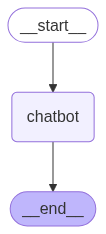

In [50]:
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [51]:
while True:
  user_input=input("User: ")
  if user_input.lower() in ["quit","q"]:
    print("Good Bye")
    break
  for event in graph.stream({'messages':("user",user_input)}):
    print(event.values())
    for value in event.values():
      print(value['messages'])
      print("Assistant:",value["messages"].content)

User: hello
dict_values([{'messages': AIMessage(content='Hello! 👋  How can I help you today? 😊\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 11, 'total_tokens': 26, 'completion_time': 0.027272727, 'prompt_time': 0.001893991, 'queue_time': 0.020254331, 'total_time': 0.029166718}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run--c7ecfd3e-c431-42ad-9355-360e68922b1d-0', usage_metadata={'input_tokens': 11, 'output_tokens': 15, 'total_tokens': 26})}])
content='Hello! 👋  How can I help you today? 😊\n' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 11, 'total_tokens': 26, 'completion_time': 0.027272727, 'prompt_time': 0.001893991, 'queue_time': 0.020254331, 'total_time': 0.029166718}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None} id='run--c7ecfd3e-c4